##### tt
This note book explains the main code runs referenced in the pdf report.
The code is seperated into different modules:
1. Market Data is responsible for downloading price data from yahoo finance and peform any data pre-processing
1. BL: is the implementation of the Black-Litterman Model

In [122]:
import yfinance as yf
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import copy
mpl.rcParams['font.family'] = 'serif'
sns.set(style="darkgrid")
from sklearn.covariance import LedoitWolf


stock_factor_dict = {
        "BRK-B": "Value",
        "AVGO": "Quality",
        "AXON": "Small-Cap",
        "WMB": "High-Dividend",
        "TMUS": "Low-Vol",
        "ORCL": "Momentum",
        "GOOGL": "Large-Cap",
        "TTFNF": "Profitability"
        }

class DataPreprocessing:
    def __init__(self,tickers,start_date,end_date,benchmark = "SPY"):
        self.tickers = tickers
        self.start_date = start_date
        self.end_date = end_date
        self.benchmark = benchmark
        self.priceData = self.download_data()

    def download_data(self):
        ticker_list = copy.deepcopy(self.tickers)
        if self.benchmark:
            ticker_list.append(self.benchmark)
        data = yf.download(ticker_list, start=self.start_date,end=self.end_date)['Close']
        return data

    def clean_data(self,data):
        clean_data = data.dropna()
        return clean_data

    def calculate_returns(self):
        returns = self.priceData.pct_change()
        return returns
    
    def benchmark_returns(self):
        return self.calculate_returns()[self.benchmark]
    
    def training_benchmark(self):
        rts = self.benchmark_returns()
        rts = rts.loc[rts.index <= '2023-12-31']
        return rts

    def backTest_benchmark(self):
        rts = self.benchmark_returns()
        rts = rts.loc[rts.index >= '2023-12-31']
        return rts

    def get_asset_returns(self):
        return self.calculate_returns()[self.tickers]

    def plot_returns(self):
        #visualize log return data
        plt.figure(figsize=(12,6))
        for ticker in self.tickers:
            plt.plot(self.calculate_returns().index,self.calculate_returns()[ticker],label=ticker)
        plt.title('Log Returns of Assets')
        plt.xlabel('Date')
        plt.ylabel('Log Returns')
        plt.legend()
        plt.show()
    
    def training_data(self):
        full_data = self.calculate_returns()
        training_data = full_data.loc[full_data.index <= '2023-12-31']
        return training_data

    def backTest_data(self):
        full_data = self.calculate_returns()
        bt_data = full_data.loc[full_data.index >= '2023-12-31']
        bt_data = bt_data[self.reduce_correlation()].dropna()
        return bt_data
    
    def reduced_training_data(self):
        rawData = self.training_data()[self.reduce_correlation()].dropna()
        rawData = rawData.rename(columns=stock_factor_dict)
        return rawData#self.training_data()[self.reduce_correlation()].dropna()
    
    def reduced_cum_returns(self):
        data = self.reduced_training_data()
        data['Benchmark'] = self.training_benchmark()

        cumulative_returns = (1 + data).cumprod() - 1
        plt.figure(figsize=(12, 6))

        # Define 9 distinct colors
        colors = sns.color_palette("tab10", n_colors=9)  # Using Seaborn's "tab10" palette for 9 unique colors

        # Plot each line with a unique color
        for i, ticker in enumerate(cumulative_returns.columns):
            plt.plot(cumulative_returns.index, cumulative_returns[ticker]*100, label=ticker, color=colors[i])

        # Plot customization
        plt.title('Cumulative Returns of Each Factor')
        plt.xlabel('Date')
        plt.ylabel('Returns (%)')
        plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=8, fontsize=10, frameon=True)
        plt.grid(linestyle=':', color='white')  # Dotted grid lines

        plt.tight_layout()  # Adjust layout to fit legend properly
        plt.show()

    def correlation_matrix(self):
        return self.training_data().corr()

    def plot_full_correlation_matrix(self):
        correlation_matrix = self.correlation_matrix()
        #Display correlation matrix heatmap
        plt.figure(figsize=(15, 12))
        # plt.imshow(correlation_matrix,cmap='coolwarm', interpolation='nearest')
        sns.heatmap(correlation_matrix, cmap='coolwarm',annot=True, linewidth=.5,fmt=".2f")
        plt.show()

    def average_correlation(self,asset,selected_assets,corr_matrix):
        if not selected_assets:
            return 0
        return corr_matrix.loc[asset, selected_assets].mean()

    def reduce_correlation(self):
        assets = {
                "Value": ["BRK-B", "JPM", "UNH"],
                "Quality": ["AVGO", "MA", "V"],
                "Small-Cap": ["AXON", "APP","DECK"],
                "Dividend": ['WMB','VICI','OKE'],
                "Low-Vol": ['L','TMUS','ADP'],
                "Momentum": ['ORCL','NVDA','COST'],
                "Large-Cap": ['AAPL','MSFT','GOOGL'],
                "Profitability":['BP','UL','TTFNF']
                }

        #Flatten the asset list for all factors
        all_assets = [asset for factor_assets in assets.values() for asset in factor_assets]
        correlation_matrix = self.correlation_matrix()
        correlation_matrix = (correlation_matrix + correlation_matrix.T)/2
        np.fill_diagonal(correlation_matrix.values,1)
        # Asset selection: One per factor with minimal correlation
        selected_assets = []
        for factor, factor_assets in assets.items():
            if len(factor_assets) == 1:
                # Automatically select the single asset for the factor
                selected_assets.append(factor_assets[0])
            else:
                #Calculate average correlation for each asset in the factor
                correlations = {
                    asset: self.average_correlation(asset, selected_assets, correlation_matrix)
                    for asset in factor_assets
                }
                #Select the asset with the lowest average correlation
                best_asset = min(correlations, key=correlations.get)
                selected_assets.append(best_asset)

        # Correlation matrix for the selected assets
        selected_corr_matrix = correlation_matrix.loc[selected_assets, selected_assets]
        return selected_assets

    def reduced_cov_matrix(self):
        selected_assets = self.reduce_correlation()
        rts = self.correlation_matrix().loc[selected_assets,selected_assets]
        return rts

    def plot_reduced_correlation(self):
        selected_corr_matrix = self.reduced_cov_matrix()#correlation_matrix.loc[selected_assets, selected_assets]
        # Visualize the reduced correlation matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(selected_corr_matrix,cmap='coolwarm', annot=True, linewidth=.5,fmt=".2f")
        plt.title("Reduced Correlation Matrix")
        plt.show()

    def risk_free_rate(self):
        #data = yf.download(['^IRX'], start='2023-12-31',end='2023-12-31')['Close']
        return 0.04208 

    def market_cap_weights(self):
        market_caps = {}
        for ticker_symbol in self.reduce_correlation():
            try:
                ticker = yf.Ticker(ticker_symbol)
                market_cap = ticker.info.get('marketCap')
                market_caps[ticker_symbol] = market_cap
            except Exception as e:
                market_caps[ticker_symbol] = None
        market_caps_df = pd.DataFrame(
            list(market_caps.items()), columns=["Asset", "MarketCap"]
        )
        total_market_cap = market_caps_df['MarketCap'].sum()
        market_caps_df['Factor'] = market_caps_df['Asset'].map(stock_factor_dict)
        market_caps_df['M_Cap_weights'] = market_caps_df['MarketCap']/total_market_cap
        return market_caps_df

    def training_data_cov_matrix(self,annualised=True):
        returns = self.reduced_training_data()
        lw = LedoitWolf()
        assets = returns.columns
        shrunk_cov_matrix = lw.fit(returns.values).covariance_
        cov_matrix = pd.DataFrame(shrunk_cov_matrix,index=assets,columns=assets)
        if annualised:
            return cov_matrix*252
        else:
            return cov_matrix
        
    def training_data_vol(self,annualised=True):
        returns = self.reduced_training_data()
        vol = returns.std()
        return vol
    
    def market_aversion(self):
        bench_returns = self.training_benchmark()
        mean_rts = bench_returns.mean()*252 - self.risk_free_rate()
        variance = (bench_returns.var())*252
        return mean_rts/variance
    
    def plot_reduced_covariance(self):
        selected_cov_matrix = self.training_data_cov_matrix()#correlation_matrix.loc[selected_assets, selected_assets]
        # Visualize the reduced correlation matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(selected_cov_matrix, annot=True, linewidth=.5,fmt=".3f")
        plt.title("Covariance Matrix")
        plt.show()


In [6]:
import statsmodels.api as sm
import warnings
import numpy as np
from pylab import mpl,plt
import pandas as pd
import scipy.optimize as sco
from MarketData import DataPreprocessing

mpl.rcParams['font.family'] = 'Sarif'

class Optimisation:
    def __init__(self,returns,cov_matrix):
        self.returns_data = returns
        self.tickers = returns.columns
        self.cov_matrix = cov_matrix
        self.CONSTRAINTS = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
        self.BOUNDARY = tuple((0,1) for x in range(len(self.tickers)))
        self.INTIAL_GUESS = np.array(len(self.tickers)*[1./len(self.tickers),])

    def mean_variance_func(self, weights, lambda_risk=2):
        portfolio_return = self.portfolio_returns(weights)
        portfolio_variance = np.dot(weights.T, np.dot(self.cov_matrix, weights))
        objective = -(portfolio_return - lambda_risk * portfolio_variance)
        return objective

    def plot_distribution_historgram(self):
        self.returns_data.hist(bins=40,figsize=(12,20))
        plt.show()
    
    def portfolio_returns(self,weights):
        return np.sum(self.returns_data.mean()*weights)*252
    
    def portfolio_volatility(self,weights):
        return np.sqrt(np.dot(weights.T, np.dot(self.cov_matrix,weights)))

    def simulate_portfolios(self):
        NUMBER_OF_SIMULATIONS = 5000
        port_returns = []
        portfolio_volatility = []
        for sample_portfolio in range(NUMBER_OF_SIMULATIONS):
            weights = np.random.random(len(self.tickers))
            weights /= np.sum(weights)
            port_returns.append(self.portfolio_returns(weights))
            portfolio_volatility.append(self.portfolio_volatility(weights))

        port_returns = np.array(port_returns)
        port_vol = np.array(portfolio_volatility)
        return {
                "Returns":port_returns,
                "Volatility":port_vol
        }

    def max_sharpe_func(self,weights):
        return -self.portfolio_returns(weights)/self.portfolio_volatility(weights)

    @classmethod
    def calculate_risk_contributions(cls,weights, cov_matrix):
        portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        marginal_contributions = np.dot(cov_matrix, weights) / portfolio_std
        risk_contributions = weights * marginal_contributions
        return risk_contributions

    # Define risk parity objective function
    def risk_parity_func(self,weights,cov_matrix):
        risk_contributions = self.calculate_risk_contributions(weights, cov_matrix)
        target_contribution = risk_contributions.mean()
        relative_diff = (risk_contributions - target_contribution) / target_contribution
        return np.sum(relative_diff ** 2)

    def risk_parity_optimisation(self):
        # Optimize weights
        result = sco.minimize(
            self.risk_parity_func, self.INTIAL_GUESS, args=(self.cov_matrix), method='SLSQP',
            bounds=self.BOUNDARY, constraints=self.CONSTRAINTS,
            options={'maxiter': 1000, 'ftol': 1e-9}
        )
        return result

    def sharpe_optimisation(self):
        return sco.minimize(self.max_sharpe_func,self.INTIAL_GUESS,method='SLSQP',constraints=self.CONSTRAINTS,bounds=self.BOUNDARY)
    
    def variance_optimisation(self):
        return sco.minimize(self.portfolio_volatility,self.INTIAL_GUESS,method='SLSQP',bounds=self.BOUNDARY,constraints=self.CONSTRAINTS)

    def markowitz_optimisation(self):
        return sco.minimize(self.mean_variance_func,self.INTIAL_GUESS,method='SLSQP',constraints=self.CONSTRAINTS,bounds=self.BOUNDARY)

    def optimisation_summary(self):
        summary = {}
        eweights = np.array(len(self.tickers)*[1./len(self.tickers),])#equal weights
        weights = pd.DataFrame()
        weights['Securities'] = self.tickers
        weights['Equal Allocation'] = np.round(eweights,4)*100
        weights['Max Sharpe'] = np.round(self.sharpe_optimisation().x,4)*100
        weights['Minimum Variance'] = np.round(self.variance_optimisation().x,4)*100
        weights['Risk Parity'] = np.round(self.risk_parity_optimisation().x,4)*100
        weights['Mean Variance'] = np.round(self.markowitz_optimisation().x,4)*100

        performance = pd.DataFrame()
        performance['Portfolio'] = ['Equal Weight','Max Sharpe','Minimum Variance']
        performance['Returns'] = [self.portfolio_returns(eweights),
                                            self.portfolio_returns(self.sharpe_optimisation().x),
                                            self.portfolio_returns(self.variance_optimisation().x)
                                            ]
        performance['Volatility'] = [self.portfolio_volatility(eweights),
                                            self.portfolio_volatility(self.sharpe_optimisation().x),
                                            self.portfolio_volatility(self.variance_optimisation().x)
                                            ]
        performance.Returns = np.round(performance.Returns,4)*100
        performance.Volatility = np.round(performance.Volatility,4)*100

        performance['Sharpe'] = performance['Returns']/performance['Volatility']
        performance = performance.set_index('Portfolio')
        summary = {'Allocation':weights,
                'Performance':performance}
        return weights

    def plot_efficient_frontier(self):
        port_simulation_results = self.simulate_portfolios()
        eweights = np.array(len(self.tickers)*[1./len(self.tickers),])#equal weights
        plt.figure(figsize=(10,6))
        plt.scatter(np.round(port_simulation_results['Volatility']*100,4),
                    np.round(port_simulation_results['Returns']*100,4),
                    c=port_simulation_results['Returns']/port_simulation_results['Volatility'],
                    marker='o',
                    cmap='coolwarm')
        plt.plot(self.portfolio_volatility(self.sharpe_optimisation().x)*100,
                self.portfolio_returns(self.sharpe_optimisation().x)*100,'r*',markersize=5.0,label='Max Sharpe')

        plt.plot(self.portfolio_volatility(eweights)*100,
                self.portfolio_returns(eweights)*100,'^',color='orange',markersize=5.0,label='Equally weighted')

        plt.plot(self.portfolio_volatility(self.variance_optimisation().x)*100,
                self.portfolio_returns(self.variance_optimisation().x)*100,'bo',markersize=5.0,label='Minimum Variance')

        plt.title('Portfolio Optimization')
        plt.legend()  # Displays the legend
        plt.xlabel('Expected Risk(Volatility) (%)')
        plt.ylabel('Expected Return (%)')
        plt.colorbar(label='Sharpe ratio')
        plt.show() 

In [57]:
import numpy as np
import matplotlib.pyplot as plt

class BlackLitterman:
    def __init__(self,weight,asset_covariance,risk_aversion):
        self.asset_weight = weight
        self.asset_covariance = asset_covariance
        self.risk_aversion = risk_aversion

    def black_litterman_return(self,equlibrium_return,tau,view_portfolios,view_change,view_uncertainty):
        ER = equlibrium_return
        S = self.asset_covariance
        t = tau
        P = view_portfolios
        Q = view_change
        O = view_uncertainty

        tS_inv = np.linalg.inv(t*S)
        O_inv = np.linalg.inv(O)

        return np.linalg.inv(tS_inv + P.T @ O_inv @ P) @ (tS_inv @ ER + P.T @ O_inv @ Q)
    
    
    def get_expected_return(self):
        return self.risk_aversion * self.asset_covariance @ self.asset_weight


    #def get_weight(self,expected_return):
    #    return np.linalg.inv(self.risk_aversion*self.asset_covariance) @ expected_return
    def get_weight(self, expected_return):
        weights = np.linalg.inv(self.risk_aversion * self.asset_covariance) @ expected_return
        normalized_weights = weights / np.sum(weights) * 100
        return normalized_weights
    
    def he_litterman_omega(self,tau,view_portfolios):
        S = self.asset_covariance
        t = tau
        P = view_portfolios
        K,N = P.shape
        O = np.zeros((K,K))

        for i in range(K):
            O[i,i] = (P[i,:] @ S @ P[i,:].T) * t
        
        return O
    
    def he_litterman_return(self,equilibrium_return,view_portfolios,view_change):
        tau = 1
        omega = self.he_litterman_omega(tau,view_portfolios)
        return self.black_litterman_return(equilibrium_return,tau,view_portfolios,view_change,omega)
    
    def idzorek_omega(self,equilibrium_return,tau,risk_free_rate,view_portfolios,view_change,view_confidence):
        ER = equilibrium_return
        S = self.asset_covariance
        t = tau
        rr = risk_free_rate
        L = self.risk_aversion
        P = view_portfolios
        Q = view_change
        C = view_confidence
        
        w_mkt = np.linalg.inv(L * S) @ ER
        
        K, N = P.shape
        O = np.zeros((K, K))
        
        # We treat each view separately
        for i in range(K):
            p = P[i,:]
            q = Q[i] - ((p.sum() != 0) * rr)
            c = C[i]
            
            D = (t/L) * (q - p @ ER) * p / (p @ S @ p.T)
            Tilt = D * ((p != 0) * c)
            
            w_target = w_mkt + Tilt
            
            def w(o):
                return np.linalg.inv(np.identity(N)/t + np.outer(p, p) @ S / o) @ (w_mkt / t + p * q / o / L)
            
            def sum_squared_difference(o):
                diff = w_target - w(o)
                return np.dot(diff, diff)
            
            O[i,i] = min(np.linspace(0,1,1000)[1:], key=sum_squared_difference)
            
        return O
    
    # A wrapper for the Black-Litterman model that uses Idzorek's new method for calculating omega
    def idzorek_return(self,equilibrium_return,risk_free_rate,view_portfolios,view_change,view_confidence):
        tau = 1
        return self.black_litterman_return(
            equilibrium_return,
            tau,
            view_portfolios,
            view_change,
            self.idzorek_omega(
                equilibrium_return,
                tau,
                risk_free_rate,
                view_portfolios,
                view_change,
                view_confidence
            )
        )
    
    # The return based on 100% confidence in the views
    def certain_return(self,equilibrium_return,asset_covariance,view_portfolios,view_change):
        ER = equilibrium_return
        S = asset_covariance
        P = view_portfolios
        Q = view_change
        return ER + S @ P.T @ np.linalg.inv(P @ S @ P.T) @ (Q - P @ ER)

In [44]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

mpl.rcParams['font.family'] = 'serif'
from sklearn.linear_model import LinearRegression

def BL_statistics(bt_data, ptf_weights):
    """
    Compute portfolio statistics including Variance, Standard Deviation, Sharpe Ratio, 
    Information Ratio, Alpha, and Beta for each strategy.
    
    Args:
    bt_data (DataFrame): Back-test data of asset returns.
    ptf_weights (DataFrame): Portfolio weights for each strategy (percentage values).

    Returns:
    DataFrame: A DataFrame containing the statistics for each strategy.
    """
    # Align weights with the index
    ptf_weights = ptf_weights.set_index('Asset')
    
    # Calculate back-tested returns for each strategy
    bt_returns = {}
    for strategy in ptf_weights.columns:
        bt_returns[strategy] = bt_data.apply(
            lambda row: np.dot(row, ptf_weights[strategy] / 100), axis=1
        )
    bt_returns = pd.DataFrame(bt_returns, index=bt_data.index)

    # Set Strategy2 as the benchmark
    benchmark = bt_returns['M_Cap_weights']

    # Initialize list to store statistics
    stats_list = []

    # Compute statistics for each strategy
    for strategy in bt_returns.columns:
        strategy_returns = bt_returns[strategy]
        
        # Annualize metrics assuming 252 trading days
        avg_return = strategy_returns.mean() * 252
        variance = strategy_returns.var() * 252
        std_dev = strategy_returns.std() * np.sqrt(252)
        
        # Sharpe Ratio (assuming zero risk-free rate)
        sharpe_ratio = avg_return / std_dev

        # Information Ratio
        tracking_error = (strategy_returns - benchmark).std() * np.sqrt(252)
        information_ratio = (avg_return - benchmark.mean() * 252) / tracking_error

        # Alpha and Beta (using Strategy2 as benchmark)
        regression = LinearRegression().fit(
            benchmark.values.reshape(-1, 1), strategy_returns.values
        )
        beta = regression.coef_[0]
        alpha = regression.intercept_ * 252

        # Append metrics to the stats list
        stats_list.append({
            'Strategy': strategy,
            'Average Return (%)': avg_return * 100,
            'Variance (%)': variance * 100,
            'Standard Deviation (%)': std_dev * 100,
            'Sharpe Ratio': sharpe_ratio,
            'Tracking Error (%)': tracking_error * 100,
            'Information Ratio': information_ratio,
            'Alpha (%)': alpha * 100,
            'Beta': beta
        })
    
    # Convert stats list to DataFrame
    statistics_df = pd.DataFrame(stats_list)
    return statistics_df
    
def equity_curve(bt_data,ptf_weights,benchmark):
    ptf_weights = ptf_weights.set_index('Securities')
    bt_returns = {}
    cumulative_returns = {} 
    colors = sns.color_palette("tab10", n_colors=9)
    for strategy in ptf_weights.columns:
        bt_returns[strategy] = bt_data.apply(lambda row: np.dot(row, list(ptf_weights[strategy]/100)), axis=1)
        cumulative_returns[strategy] = (1 + bt_returns[strategy]).cumprod() - 1

    cumulative_returns['Benchmark'] = (1+benchmark).cumprod()-1
    # Plot the cumulative returns
    plt.figure(figsize=(12, 6))
    for i,x in enumerate(cumulative_returns):
        rts = cumulative_returns[x]*100
        rts.plot(label=x,color=colors[i])

    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns (%)')
    plt.title('Cumulative Returns of Strategies vs Benchmark')
    plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=8, fontsize=10, frameon=True)
    plt.grid(which='both', linestyle=':', axis='both')  # Dotted symmetrical grid lines
    #plt.axhline(0, color='black', linewidth=0.8, linestyle='--')  # Symmetry at y=0
    plt.tight_layout()
    plt.tight_layout()  # Adjust layout to fit legend properly
    plt.show()

In [58]:
tickers=['BRK-B','JPM','UNH','AVGO','MA','V','AXON','APP','DECK',
        'WMB','VICI','OKE','L','TMUS','ADP','ORCL','NVDA','COST',
        'AAPL','MSFT','GOOGL','BP','UL','TTFNF']

In [125]:
#Data pre-processing
preprocessor = DataPreprocessing(tickers=tickers, start_date='2021-01-01', end_date='2024-12-31')
training_data = preprocessor.reduced_training_data()
training_data_cov_matrix = np.array(preprocessor.training_data_cov_matrix())

[*********************100%***********************]  25 of 25 completed


##### Initial Correlation Matrix before reduction

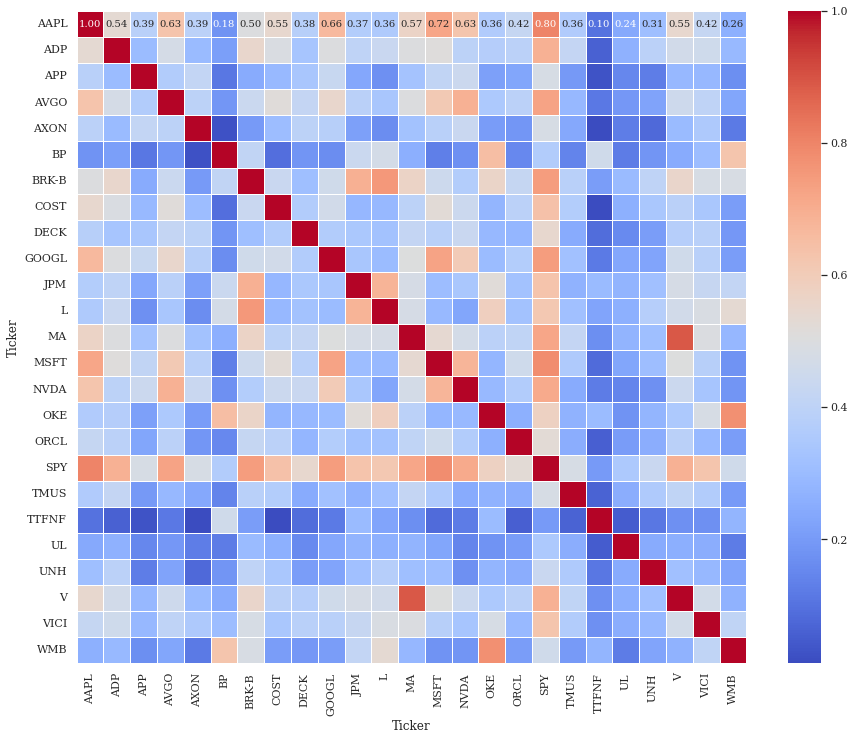

In [19]:
preprocessor.plot_full_correlation_matrix()

##### Reduced Correlation Matrix

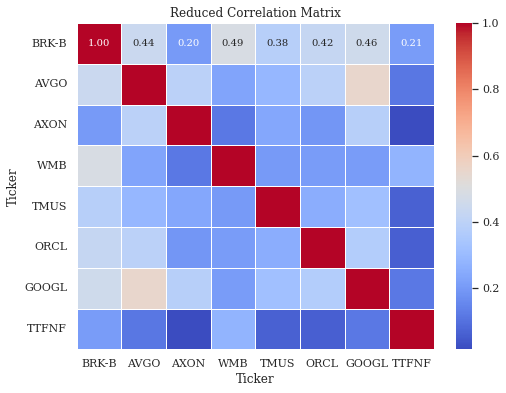

In [21]:
preprocessor.plot_reduced_correlation()

In [130]:
preprocessor.training_data_vol()*100

Ticker
Value            1.109294
Quality          2.071492
Small-Cap        2.827370
High-Dividend    1.534160
Low-Vol          1.538436
Momentum         1.888453
Large-Cap        1.999362
Profitability    2.654025
dtype: float64

###### Market Cap

In [12]:
market_weight = preprocessor.market_cap_weights()
market_weight["MarketCap"] = market_weight["MarketCap"].apply(lambda x: f"{x:,}")
market_weight["M_Cap_weights"] = market_weight["M_Cap_weights"].apply(lambda x: f"{x:.2%}")
market_weight[['Asset','Factor','MarketCap','M_Cap_weights']]

,Asset,Factor,MarketCap,M_Cap_weights
0,BRK-B,Value,"957,482,795,008",18.15%
1,AVGO,Quality,"1,056,015,319,040",20.01%
2,AXON,Small-Cap,"43,364,577,280",0.82%
3,WMB,High-Dividend,"68,301,131,776",1.29%
4,TMUS,Low-Vol,"247,718,199,296",4.69%
5,ORCL,Momentum,"430,508,081,152",8.16%
6,GOOGL,Large-Cap,"2,345,239,838,720",44.45%
7,TTFNF,Profitability,"127,889,416,192",2.42%


##### Initial Risk Aversion

In [25]:
risk_aversion = 2.37
BL = BlackLitterman(weight=np.array(preprocessor.market_cap_weights()['M_Cap_weights']),
                     asset_covariance=training_data_cov_matrix,
                     risk_aversion=risk_aversion)
equilibrium_return = BL.get_expected_return()

market_weight['Implied Return'] = equilibrium_return
market_weight["Implied Return"] = market_weight["Implied Return"].apply(lambda x: f"{x:.2%}")
market_weight[['Asset','Factor','MarketCap','M_Cap_weights','Implied Return']]

,Asset,Factor,MarketCap,M_Cap_weights,Implied Return
0,BRK-B,Value,957482795008,0.181461,5.98%
1,AVGO,Quality,1056015319040,0.200135,13.28%
2,AXON,Small-Cap,43364577280,0.008218,10.09%
3,WMB,High-Dividend,68301131776,0.012944,4.12%
4,TMUS,Low-Vol,247718199296,0.046947,5.42%
5,ORCL,Momentum,430508081152,0.081589,8.40%
6,GOOGL,Large-Cap,2345239838720,0.444467,15.48%
7,TTFNF,Profitability,127889416192,0.024237,4.27%


#### Investment Views

In [26]:
#P-matrix
view_portfolios = np.array([[0,  0,  0,   0,  0,   0, 1, 0],
                        [-1, 1,  0,   0,  0,   0, 0, 0],
                        [0,  0, 1, -1, 1, -1, 0, 0]])
# The change from equilibrium that we expect, Q
view_change = np.array([0.18, 0.015, 0.02])
market_weight = preprocessor.market_cap_weights()
he_return = BL.he_litterman_return(equilibrium_return=equilibrium_return,view_portfolios=view_portfolios,view_change=view_change)
he_litterman_weight = BL.get_weight(he_return)
table6 = market_weight[['Asset','Factor','M_Cap_weights']]
table6['M_Returns'] = equilibrium_return
table6['New returns'] = he_return
table6['New weights'] = he_litterman_weight
table6['Difference E[R] − Π'] = table6['New returns'] - table6['M_Returns']
table6['Difference wˆ − wmkt'] = table6['New weights'] - table6['M_Cap_weights']
table6 = table6[['Asset','Factor','New returns','M_Returns','Difference E[R] − Π','New weights','M_Cap_weights','Difference wˆ − wmkt']]
table6

,Asset,Factor,New returns,M_Returns,Difference E[R] − Π,New weights,M_Cap_weights,Difference wˆ − wmkt
0,BRK-B,Value,0.067149,0.059793,0.007355,0.327936,0.181461,1.464748e-01
1,AVGO,Quality,0.113877,0.132844,-0.018967,0.053660,0.200135,-1.464748e-01
2,AXON,Small-Cap,0.095251,0.100904,-0.005653,0.006437,0.008218,-1.780991e-03
3,WMB,High-Dividend,0.044966,0.041158,0.003808,0.014725,0.012944,1.780991e-03
4,TMUS,Low-Vol,0.056013,0.054188,0.001825,0.045166,0.046947,-1.780991e-03
5,ORCL,Momentum,0.084794,0.083958,0.000836,0.083370,0.081589,1.780991e-03
6,GOOGL,Large-Cap,0.161960,0.154785,0.007175,0.520072,0.444467,7.560460e-02
7,TTFNF,Profitability,0.045385,0.042720,0.002665,0.024237,0.024237,-6.938894e-18


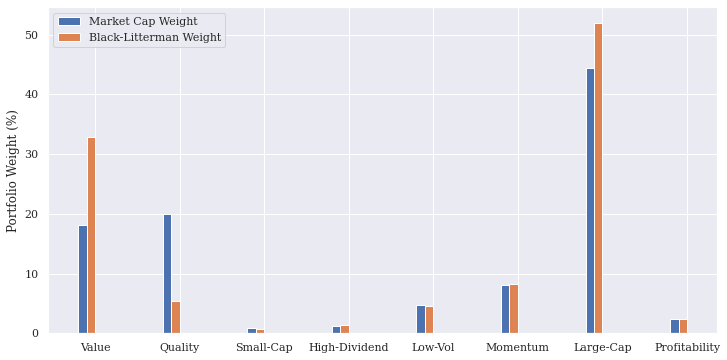

In [33]:
x = np.arange(len(table6['Factor']))
bar_width = 0.1

fig, ax = plt.subplots(figsize=(12, 6))
market_b = ax.bar(x + bar_width * -1.5, np.array(preprocessor.market_cap_weights()['M_Cap_weights'])*100, bar_width, label="Market Cap Weight")
he_lit_b = ax.bar(x + bar_width * -0.5, he_litterman_weight * 100, bar_width, label="Black-Litterman Weight")

ax.set_ylabel("Portfolio Weight (%)")
ax.set_xticks(x)
ax.set_xticklabels(table6['Factor'])
ax.legend()

plt.show()

In [46]:
import warnings
warnings.filterwarnings('ignore')
backTest_data = preprocessor.backTest_data()
bt_benchmark = preprocessor.backTest_benchmark()
weights = table6[['Asset','New weights', 'M_Cap_weights']]
result = BL_statistics(bt_data=backTest_data,ptf_weights=weights)
result['Strategy'] = ['Black Litterman Weight','Market Cap Weight']
result.set_index('Strategy',inplace=True)
result.T

Strategy,Black Litterman Weight,Market Cap Weight
Average Return (%),0.380562,0.448353
Variance (%),0.000343,0.000427
Standard Deviation (%),0.185213,0.206656
Sharpe Ratio,2.054732,2.169564
Tracking Error (%),0.079387,0.000000
Information Ratio,-0.853924,NaN
Alpha (%),0.009400,0.000000
Beta,0.827836,1.000000


#### Different Investor Types


In [72]:
BL_trustee = BlackLitterman(weight=np.array(preprocessor.market_cap_weights()['M_Cap_weights']),
                     asset_covariance=training_data_cov_matrix,
                     risk_aversion=1)
trustee_return = BL_trustee.get_expected_return()
trustee_he_return = BL_trustee.he_litterman_return(equilibrium_return=trustee_return,view_portfolios=view_portfolios,view_change=view_change)
trustee_litterman_weight = BL_trustee.get_weight(trustee_he_return)

#Average Investor
BL_average = BlackLitterman(weight=np.array(preprocessor.market_cap_weights()['M_Cap_weights']),
                     asset_covariance=training_data_cov_matrix,
                     risk_aversion=4)
average_return = BL_average.get_expected_return()
average_he_return = BL_average.he_litterman_return(equilibrium_return=average_return,view_portfolios=view_portfolios,view_change=view_change)
average_litterman_weight = BL_average.get_weight(average_he_return)

#Average Investor
BL_averse = BlackLitterman(weight=np.array(preprocessor.market_cap_weights()['M_Cap_weights']),
                     asset_covariance=training_data_cov_matrix,
                     risk_aversion=10)
averse_return = BL_averse.get_expected_return()
averse_he_return = BL_averse.he_litterman_return(equilibrium_return=averse_return,view_portfolios=view_portfolios,view_change=view_change)
averse_litterman_weight = BL_averse.get_weight(averse_he_return)

In [76]:
table7 = market_weight[['Asset','Factor']]
table7['Risk seeking'] = trustee_litterman_weight    
table7['Risk Neutral'] = average_litterman_weight
table7['Risk Averse'] = averse_litterman_weight
table7['Black - Litterman'] = he_litterman_weight*100
table7

,Asset,Factor,Risk seeking,Risk Neutral,Risk Averse,Black - Litterman
0,BRK-B,Value,23.068573,34.324271,38.914147,32.793582
1,AVGO,Quality,0.797992,7.155296,9.747694,5.366008
2,AXON,Small-Cap,0.297105,0.754296,0.940730,0.643741
3,WMB,High-Dividend,1.026500,1.546101,1.757985,1.472534
4,TMUS,Low-Vol,2.719367,4.964133,5.879510,4.516628
5,ORCL,Momentum,5.319842,9.007835,10.511734,8.337040
6,GOOGL,Large-Cap,65.254710,39.613450,29.157392,52.007181
7,TTFNF,Profitability,1.515910,2.634618,3.090807,2.423746


In [131]:
risk_aversions = np.arange(1, 10.5, 0.5).tolist()
risk_avs = {}
for x in risk_aversions:
    BL_obj = BlackLitterman(weight=np.array(preprocessor.market_cap_weights()['M_Cap_weights']),
                     asset_covariance=training_data_cov_matrix,
                         risk_aversion=x)
    bl_return = BL_obj.get_expected_return()
    bl_he_return = BL_obj.he_litterman_return(equilibrium_return=bl_return,view_portfolios=view_portfolios,view_change=view_change)
    risk_avs[x] = BL_obj.get_weight(bl_he_return)

df = pd.DataFrame(data=risk_avs)

In [132]:
df['Factor'] = list(table7['Factor'])
df = df.set_index('Factor')
df

,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0,5.5,6.0,6.5,7.0,7.5,8.0,8.5,9.0,9.5,10.0
Factor,,,,,,,,,,,,,,,,,,,
Value,23.039261,26.579372,29.048013,30.867817,32.264835,33.371068,34.268621,35.011641,35.636802,36.174990,36.635390,37.038671,37.390275,37.708210,37.987554,38.238592,38.465101,38.668532,38.855885
Quality,0.841803,2.855323,4.258910,5.293922,6.088475,6.717644,7.227265,7.649833,8.005372,8.308375,8.570144,8.810093,9.009465,9.187204,9.346107,9.489882,9.618737,9.733450,9.840024
Small-Cap,0.311411,0.458809,0.561615,0.637387,0.695555,0.741616,0.779012,0.809950,0.835981,0.858250,0.877407,0.894418,0.908905,0.921998,0.933627,0.944040,0.953470,0.961708,0.969506
High-Dividend,1.030537,1.195213,1.310064,1.394718,1.459705,1.511165,1.552843,1.587405,1.616484,1.641007,1.662289,1.680899,1.697361,1.711619,1.724601,1.736237,1.746764,1.756391,1.765099
Low-Vol,2.718941,3.426220,3.919514,4.283100,4.562216,4.783235,4.962691,5.111146,5.236052,5.342272,5.434225,5.512764,5.582751,5.644894,5.700660,5.750613,5.795830,5.836108,5.873506
Momentum,5.380003,6.556164,7.376476,7.981097,8.445249,8.812789,9.111224,9.358095,9.565807,9.741999,9.894933,10.026246,10.142996,10.245888,10.338625,10.421709,10.496903,10.564425,10.626621
Large-Cap,65.170841,57.071187,51.423236,47.259604,44.063289,41.532277,39.479203,37.779220,36.348892,35.125940,34.072872,33.145116,32.341704,31.622929,30.983931,30.409276,29.891136,29.427265,28.998703
Profitability,1.507205,1.857711,2.102172,2.282354,2.420675,2.530206,2.619141,2.692710,2.754610,2.807167,2.852740,2.891793,2.926545,2.957258,2.984894,3.009652,3.032060,3.052122,3.070656


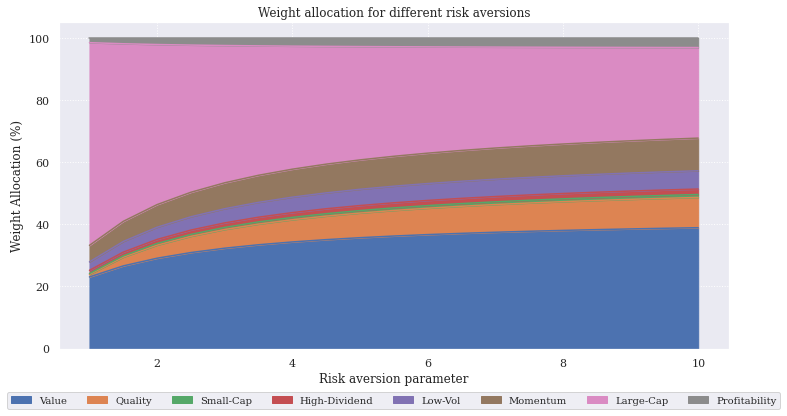

In [114]:
# Plot
df_T = df.T
# Plot

# Plot
df_T.plot.area(figsize=(12,6))
plt.xlabel('Risk aversion parameter')
plt.ylabel('Weight Allocation (%)')
plt.title('Weight allocation for different risk aversions')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=8, fontsize=10, frameon=True)
plt.grid(which='both', linestyle=':', axis='both')  # Dotted symmetrical grid lines
plt.show()

#### Comparison with Otpimisation Methods

In [112]:
optimisation = Optimisation(returns=training_data,cov_matrix=training_data_cov_matrix)
optimisation_weights = optimisation.optimisation_summary()
optimisation_weights['Black-litterman'] = he_litterman_weight*100
optimisation_weights

,Securities,Equal Allocation,Max Sharpe,Minimum Variance,Risk Parity,Mean Variance,Black-litterman
0,Value,12.5,14.58,44.09,16.79,0.00,32.793582
1,Quality,12.5,28.77,0.00,9.65,48.66,5.366008
2,Small-Cap,12.5,12.96,4.09,9.04,17.57,0.643741
3,High-Dividend,12.5,25.33,16.03,15.35,21.88,1.472534
4,Low-Vol,12.5,0.00,20.89,15.45,0.00,4.516628
5,Momentum,12.5,8.06,8.01,12.24,0.60,8.337040
6,Large-Cap,12.5,0.00,0.34,10.04,0.00,52.007181
7,Profitability,12.5,10.30,6.57,11.45,11.29,2.423746


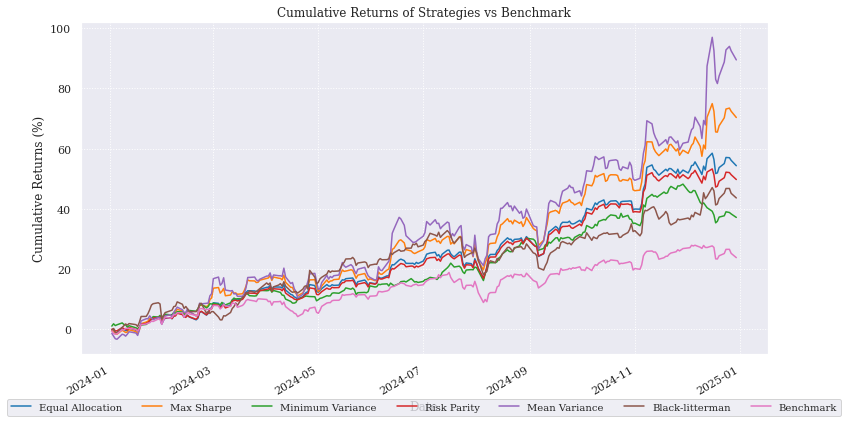

In [113]:
 ##Back test and Performance Analysis
backTest_data = preprocessor.backTest_data()
bt_benchmark = preprocessor.backTest_benchmark()
equity_curve(backTest_data,optimisation_weights,bt_benchmark)